# Minimal example in pyro

## Setup

### Import libraries

In [1]:
# may need development version of pyro
# when running on python 3.10
# see: https://github.com/pyro-ppl/pyro/pull/3101
# !sudo pip install git+https://github.com/pyro-ppl/pyro.git

In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
print(os.environ["CUBLAS_WORKSPACE_CONFIG"])

:4096:8


In [1]:
from inspect import getmembers
from pprint import pprint
from types import FunctionType

import arviz as az
import numpy as np
import torch

In [2]:
# torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.benchmark=False
# torch.backends.cudnn.deterministic=True

In [3]:
SEED = 1234

In [4]:
np.random.seed(seed=SEED)
torch.manual_seed(SEED)

In [2]:
import pyro
import pyro.distributions as dist

from pyro.infer import MCMC, NUTS, Predictive
import platform

# az.style.use("arviz-darkgrid")

In [3]:
print(pyro.settings.get())

AttributeError: module 'pyro' has no attribute 'settings'

In [4]:
print(platform.python_version())
print(pyro.__version__)
print(torch.__version__)
print(az.__version__)

3.9.16
1.8.1+06911dc
1.13.1.post200
0.14.0


In [5]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


### Setup plotting

In [6]:
import matplotlib.font_manager
import matplotlib.pyplot as plt

# import matplotlib_inline

In [7]:
fonts_path = "/usr/share/texmf/fonts/opentype/public/lm/" #ubuntu
# fonts_path = "~/Library/Fonts/" # macos
# fonts_path = "/usr/share/fonts/OTF/"  # arch
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmsans10-regular.otf")
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmroman10-regular.otf")

In [8]:
# https://stackoverflow.com/a/36622238/446907
%config InlineBackend.figure_formats = ['svg']

In [9]:
plt.style.use("default")  # reset default parameters
# https://stackoverflow.com/a/3900167/446907
plt.rcParams.update(
    {
        "font.size": 16,
        "font.family": ["sans-serif"],
        "font.serif": ["Latin Modern Roman"] + plt.rcParams["font.serif"],
        "font.sans-serif": ["Latin Modern Sans"] + plt.rcParams["font.sans-serif"],
    }
)

### Utility functions

In [10]:
def attributes(obj):
    disallowed_names = {
        name for name, value in getmembers(type(obj)) if isinstance(value, FunctionType)
    }
    return {
        name: getattr(obj, name)
        for name in dir(obj)
        if name[0] != "_" and name not in disallowed_names and hasattr(obj, name)
    }


def print_attributes(obj):
    pprint(attributes(obj))

## Execute

### Define sample data

In [11]:
N_obs = 100

In [12]:
# observations = dist.Normal(0, 1).sample([N_obs])
# observations = torch.randn(N_obs, names=(None,))
observations = torch.randn(N_obs)

### Define model

In [13]:
def model(obs=None):
    mu = pyro.sample("mu", dist.Normal(0, 1))
    sigma = pyro.sample("sigma", dist.HalfNormal(1))
    with pyro.plate("N_obs", N_obs):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=obs)

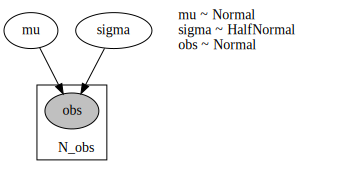

In [14]:
pyro.render_model(
    model, model_args=(observations,), render_distributions=True, render_params=True
)

### Fit model

In [15]:
R = 1000

In [16]:
kernel = NUTS(model, jit_compile=False)

In [21]:
mcmc = MCMC(kernel, warmup_steps=500, num_samples=R, num_chains=4)

Warmup [1]:   0%|          | 0/1500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1500 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/1500 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/1500 [00:00, ?it/s]

In [22]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [23]:
mcmc.run(observations)

terminate called after throwing an instance of 'c10::Error'
  what():  CUDA error: initialization error
Exception raised from c10_cuda_check_implementation at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1673738523684/work/c10/cuda/CUDAException.cpp:31 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >) + 0x68 (0x7fd4473bdd28 in /opt/conda/envs/api/lib/python3.9/site-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&) + 0xf3 (0x7fd447383a0d in /opt/conda/envs/api/lib/python3.9/site-packages/torch/lib/libc10.so)
frame #2: c10::cuda::c10_cuda_check_implementation(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > con

KeyboardInterrupt: 

In [18]:
posterior_samples = mcmc.get_samples(group_by_chain=False)

In [19]:
# rng_key, rng_key_ = jax.random.split(rng_key)
posterior_predictive = Predictive(model, posterior_samples)
posterior_predictions = posterior_predictive()

In [20]:
[v.shape for k, v in posterior_predictions.items()]

[torch.Size([4000, 100])]

In [21]:
# rng_key, rng_key_ = jax.random.split(rng_key)
prior_predictive = Predictive(model, num_samples=500)
prior_predictions = prior_predictive()

In [22]:
[v.shape for k, v in prior_predictions.items()]

[torch.Size([500, 1]), torch.Size([500, 1]), torch.Size([500, 100])]

### Organize output data

In [23]:
data = az.from_pyro(
    mcmc,
    prior=prior_predictions,
    posterior_predictive=posterior_predictions,
)

In [24]:
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

### Evaluate model

#### Plot autocorrelation to evaluate MCMC chain mixing

array([[<AxesSubplot:title={'center':'mu\n0'}>,
        <AxesSubplot:title={'center':'mu\n1'}>,
        <AxesSubplot:title={'center':'mu\n2'}>,
        <AxesSubplot:title={'center':'mu\n3'}>],
       [<AxesSubplot:title={'center':'sigma\n0'}>,
        <AxesSubplot:title={'center':'sigma\n1'}>,
        <AxesSubplot:title={'center':'sigma\n2'}>,
        <AxesSubplot:title={'center':'sigma\n3'}>]], dtype=object)

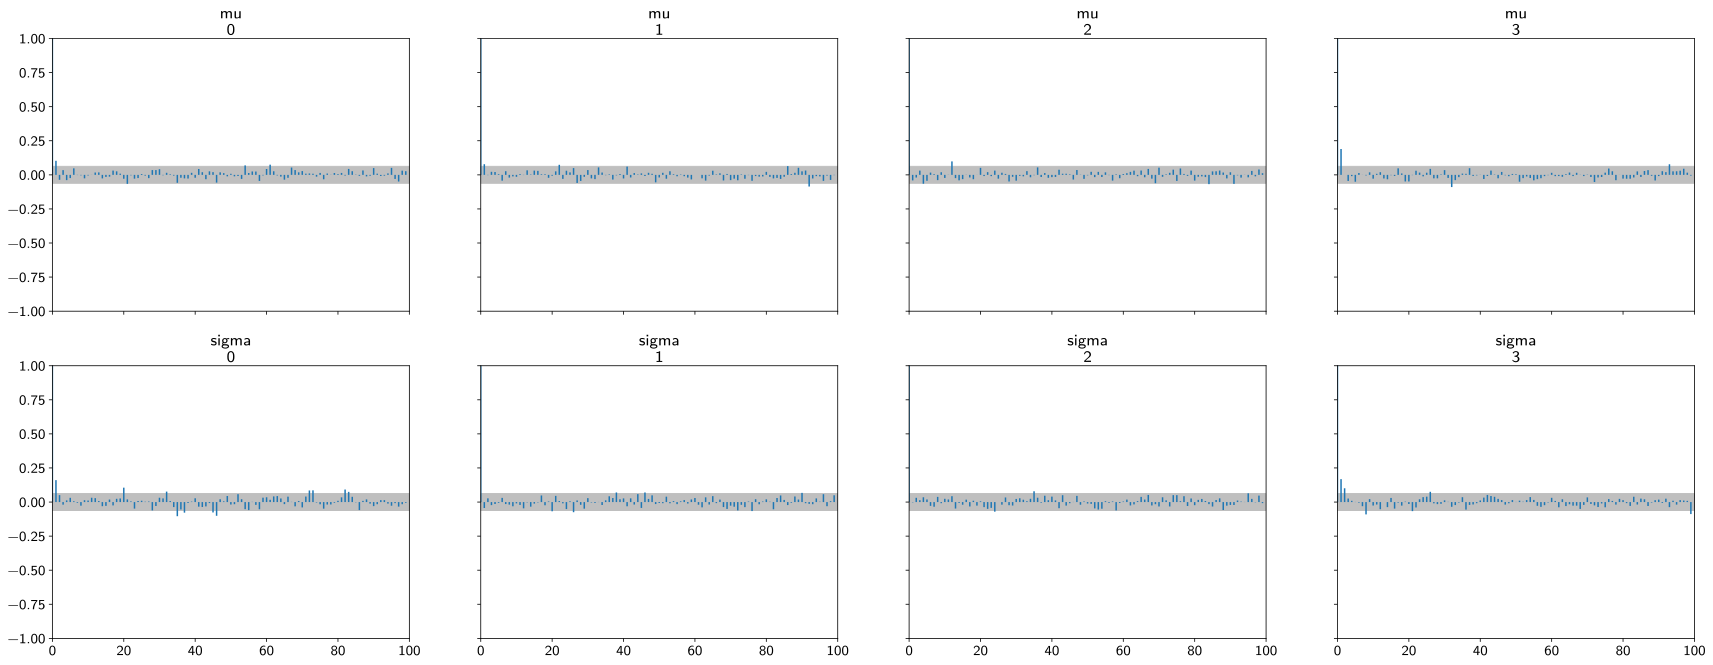

In [25]:
az.plot_autocorr(data, var_names=["mu", "sigma"])

#### Plot prior and posterior predictive distributions

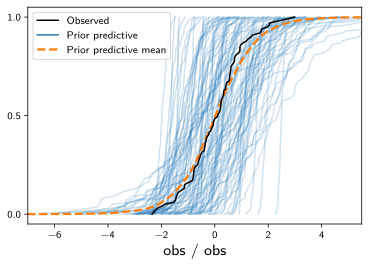

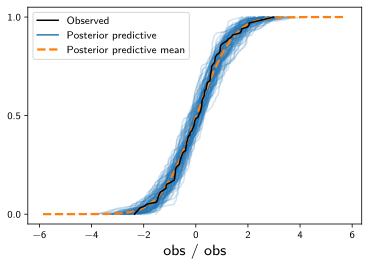

In [26]:
ax_pr_pred_cum = az.plot_ppc(
    data,
    group="prior",
    data_pairs={"obs": "obs"},
    kind="cumulative",
    num_pp_samples=100,
    random_seed=7,
)
ax_pr_pred_cum.set_xlim([-7, 5.5])
az.plot_ppc(
    data,
    group="posterior",
    data_pairs={"obs": "obs"},
    kind="cumulative",
    num_pp_samples=100,
    random_seed=7,
);

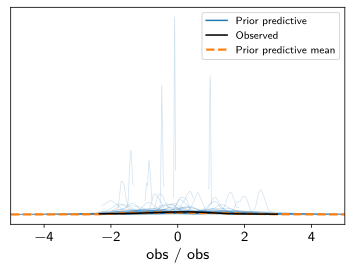

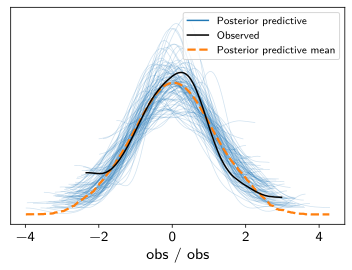

In [27]:
ax_pr_pred = az.plot_ppc(
    data,
    group="prior",
    data_pairs={"obs": "obs"},
    num_pp_samples=100,
    random_seed=7,
)
ax_pr_pred.set_xlim([-5, 5])
az.plot_ppc(
    data,
    group="posterior",
    data_pairs={"obs": "obs"},
    num_pp_samples=100,
    random_seed=7,
);

#### Characterize posterior distribution

array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

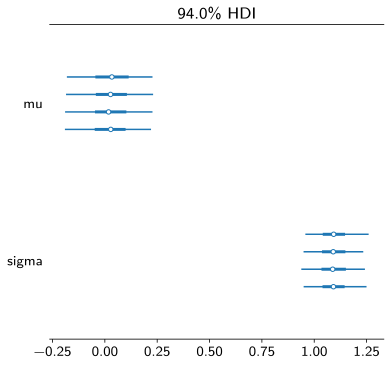

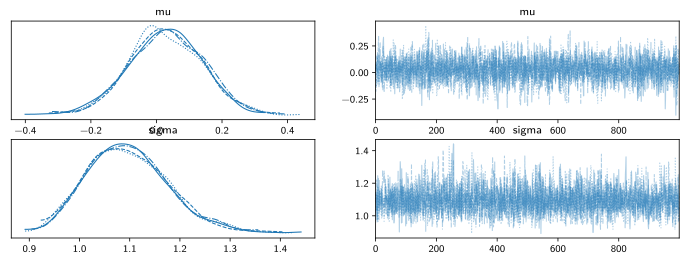

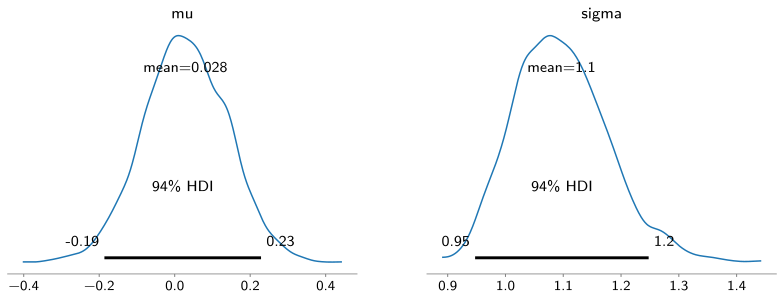

In [28]:
az.plot_forest(data)
az.plot_trace(data)
az.plot_posterior(data)